In [45]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import string
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
import emoji
nltk.download('punkt')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from keras.layers import LSTM, Dense, SimpleRNN, Embedding, Flatten, Dropout
from keras.activations import softmax
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wafts\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wafts\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [46]:
# df = pd.read_csv('/content/final_preprocessed_dataset.csv')
df = pd.read_csv("DATA/TRAINING DATASET/final_preprocessed_dataset_undersampling.csv")

df.head()

,created_at,full_text_processed,label
0,06/04/2025,besides issue genocide drc even years buy one,1.0
1,06/04/2025,anybody needs chip inserted brain named fafo s...,0.0
2,06/04/2025,2ledged support justice dignity peace gaza joi...,0.0
3,06/04/2025,taking position gaza taking position gaza one ...,0.0
4,06/04/2025,0hildren gaza stand proof world looked away do...,0.0


In [47]:
# Rename columns
df.rename(columns={'full_text_processed': 'text', 'label': 'label'}, inplace=True)
df.head()

,created_at,text,label
0,06/04/2025,besides issue genocide drc even years buy one,1.0
1,06/04/2025,anybody needs chip inserted brain named fafo s...,0.0
2,06/04/2025,2ledged support justice dignity peace gaza joi...,0.0
3,06/04/2025,taking position gaza taking position gaza one ...,0.0
4,06/04/2025,0hildren gaza stand proof world looked away do...,0.0


In [48]:
# Mapping label
# df['label'] = df['label'].map({'p': 2, 'n': 1, 'c': 0})


print(df['label'].unique())

df = df.dropna(subset=['label'])

print(df['label'].unique())

df.head()



[ 1.  0.  2. nan]
[1. 0. 2.]


,created_at,text,label
0,06/04/2025,besides issue genocide drc even years buy one,1.0
1,06/04/2025,anybody needs chip inserted brain named fafo s...,0.0
2,06/04/2025,2ledged support justice dignity peace gaza joi...,0.0
3,06/04/2025,taking position gaza taking position gaza one ...,0.0
4,06/04/2025,0hildren gaza stand proof world looked away do...,0.0


In [49]:
df.shape

(1471, 3)

In [50]:
# Convert 'Text' column to lowercase
df['text'] = df['text'].str.lower()
df.head()

,created_at,text,label
0,06/04/2025,besides issue genocide drc even years buy one,1.0
1,06/04/2025,anybody needs chip inserted brain named fafo s...,0.0
2,06/04/2025,2ledged support justice dignity peace gaza joi...,0.0
3,06/04/2025,taking position gaza taking position gaza one ...,0.0
4,06/04/2025,0hildren gaza stand proof world looked away do...,0.0


In [51]:
# Function to remove HTML tags from text
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

# Remove HTML tags from 'text' column
df['text'] = df['text'].apply(remove_html_tags)

In [52]:
df.head()

,created_at,text,label
0,06/04/2025,besides issue genocide drc even years buy one,1.0
1,06/04/2025,anybody needs chip inserted brain named fafo s...,0.0
2,06/04/2025,2ledged support justice dignity peace gaza joi...,0.0
3,06/04/2025,taking position gaza taking position gaza one ...,0.0
4,06/04/2025,0hildren gaza stand proof world looked away do...,0.0


In [53]:
# Define a function to remove URLs using regular expressions
def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)

# Apply the function to the 'text' column
df['text'] = df['text'].apply(remove_urls)

In [54]:
df.head()

,created_at,text,label
0,06/04/2025,besides issue genocide drc even years buy one,1.0
1,06/04/2025,anybody needs chip inserted brain named fafo s...,0.0
2,06/04/2025,2ledged support justice dignity peace gaza joi...,0.0
3,06/04/2025,taking position gaza taking position gaza one ...,0.0
4,06/04/2025,0hildren gaza stand proof world looked away do...,0.0


In [55]:
string.punctuation

# Define the punctuation characters to remove
punctuation = string.punctuation

In [56]:
# Function to remove punctuation from text
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuation))

# Apply remove_punctuation function to 'text' column
df['text'] = df['text'].apply(remove_punctuation)

In [57]:
df.head()

,created_at,text,label
0,06/04/2025,besides issue genocide drc even years buy one,1.0
1,06/04/2025,anybody needs chip inserted brain named fafo s...,0.0
2,06/04/2025,2ledged support justice dignity peace gaza joi...,0.0
3,06/04/2025,taking position gaza taking position gaza one ...,0.0
4,06/04/2025,0hildren gaza stand proof world looked away do...,0.0


In [58]:
# Define a dictionary of chat word mappings
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [59]:
# Function to replace chat words with their full forms
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

# Apply replace_chat_words function to 'text' column
df['text'] = df['text'].apply(replace_chat_words)

In [60]:
# Download NLTK stopwords corpus
nltk.download('stopwords')

# Get English stopwords from NLTK
stop_words = set(stopwords.words('english'))

# Function to remove stop words from text
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply remove_stopwords function to 'text' column
df['text'] = df['text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wafts\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
# Function to remove emojis from text
def remove_emojis(text):
    return emoji.demojize(text)

# Apply remove_emojis function to 'text' column
df['text'] = df['text'].apply(remove_emojis)

In [62]:
# Intilize Lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Apply 
df['Text_lemmatized'] = df['text'].apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(word , pos='v') for word in x.split()]))

# Head
df.head()

,created_at,text,label,Text_lemmatized
0,06/04/2025,besides issue genocide drc even years buy one,1.0,besides issue genocide drc even years buy one
1,06/04/2025,anybody needs chip inserted brain named fafo s...,0.0,anybody need chip insert brain name fafo satan...
2,06/04/2025,2ledged support justice dignity peace gaza joi...,0.0,2ledged support justice dignity peace gaza joi...
3,06/04/2025,taking position gaza taking position gaza one ...,0.0,take position gaza take position gaza one live...
4,06/04/2025,0hildren gaza stand proof world looked away do...,0.0,0hildren gaza stand proof world look away dont...


In [63]:
X = df['text']
y = df['label']

# Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
tokenizer = Tokenizer(oov_token = 'nothing')
tokenizer.fit_on_texts(X_train)


In [65]:
tokenizer.document_count

1176

In [66]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [67]:
# Max Len in X_train_sequences
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 45


In [68]:
# Perform padding on X_train and X_test sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

In [69]:
# Print the padded sequences for X_train and X_test
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)

X_train_padded:
[[1986  709    6 ...    0    0    0]
 [1987    2  245 ...    0    0    0]
 [   2    4   17 ...    0    0    0]
 ...
 [4780 1796    2 ...    0    0    0]
 [  35   41   42 ...    0    0    0]
 [   2    4  112 ...    0    0    0]]

X_test_padded:
[[ 237  237 2916 ...    0    0    0]
 [ 305    2 1393 ...    0    0    0]
 [   2    4   17 ...    0    0    0]
 ...
 [  19 1574 1575 ...    0    0    0]
 [1129  194  193 ...    0    0    0]
 [  93  602    7 ...    0    0    0]]


In [70]:
# Embedding Input Size / Vocabulary Size 
input_Size = int(np.max(X_train_padded)) + 1
input_Size

4788

In [71]:
X_train_padded = X_train_padded.reshape((X_train_padded.shape[0], X_train_padded.shape[1], 1))
X_test_padded = X_test_padded.reshape((X_test_padded.shape[0], X_test_padded.shape[1], 1))


In [72]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)


In [73]:
vocab_size = len(tokenizer.word_index) + 1
print("Vocab size:", vocab_size)


Vocab size: 4787


In [74]:
# Define the model
model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=maxlen))

# Use LSTM instead of SimpleRNN for better capturing long-term dependencies
model.add(LSTM(32))  

# Add dropout to prevent overfitting
model.add(Dropout(0.3))
 

# Output layer with sigmoid activation for binary classification
model.add(Dense(3, activation='softmax')) 

# Compile the model
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

model.build(input_shape=(None, maxlen))
# Print model summary
model.summary()

d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 45, 64)         │       306,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 318,883 (1.22 MB)

 Trainable params: 318,883 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 45, 64)         │       306,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 318,883 (1.22 MB)

 Trainable params: 318,883 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
# early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [77]:
# Model Train 
history = model.fit(
    X_train_padded, 
    y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_test_padded, y_test)
    )

Epoch 1/50
 1/37 ━━━━━━━━━━━━━━━━━━━━ 2:16 4s/step - accuracy: 0.3750 - loss: 1.0983

InvalidArgumentError: Graph execution error:

Detected at node sequential_6_1/embedding_6_1/GatherV2 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\wafts\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\wafts\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\wafts\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3098, in run_cell

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3153, in _run_cell

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3362, in run_cell_async

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3607, in run_ast_nodes

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3667, in run_code

  File "C:\Users\wafts\AppData\Local\Temp\ipykernel_19588\2633268085.py", line 2, in <module>

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 377, in fit

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 220, in function

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 133, in multi_step_on_iterator

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 114, in one_step_on_data

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 58, in train_step

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\layers\layer.py", line 936, in __call__

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\ops\operation.py", line 58, in __call__

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\models\sequential.py", line 220, in call

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\models\functional.py", line 183, in call

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\ops\function.py", line 177, in _run_through_graph

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\models\functional.py", line 648, in call

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\layers\layer.py", line 936, in __call__

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\ops\operation.py", line 58, in __call__

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\layers\core\embedding.py", line 150, in call

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\ops\numpy.py", line 5581, in take

  File "d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 2274, in take

indices[22,10] = 4787 is not in [0, 4787)
	 [[{{node sequential_6_1/embedding_6_1/GatherV2}}]] [Op:__inference_multi_step_on_iterator_8424]

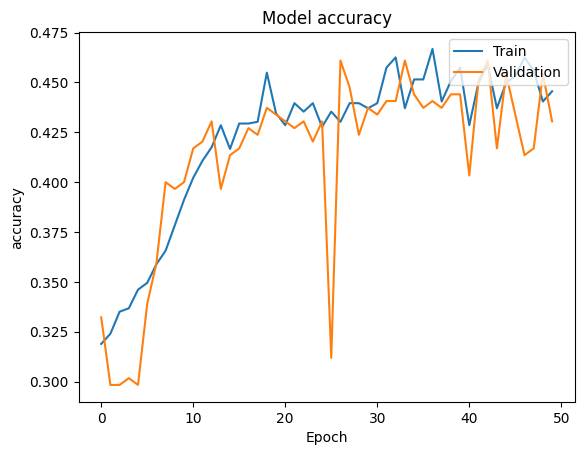

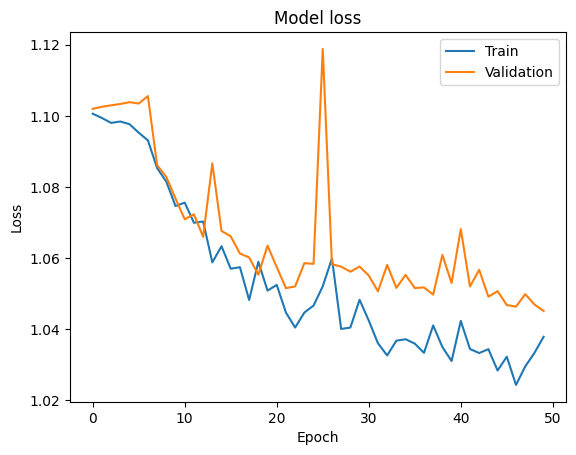

In [ ]:
# Plotting the training and testing accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the training and testing loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
df['label'].value_counts()


label
1.0    492
0.0    490
2.0    489
Name: count, dtype: int64